date.py Functions:

- **pydate_to_exceldate(d: dt.date)**: Converts a Datetime object to an Excel date
- **exceldate_to_pydate(d: int)**: Converts an Excel date to a Datetime object
- **create_excel_date(arg)**: Takes an integer or Datetime object to turn into an Excel date
- **create_relativedelta(n: int, unit: str)**: Takes a spliced tenor object to output a step of time
- **date_step(date: int, step_size: int, step_unit: str, preserve_eom: bool = False)**: Takes an Excel date and spliced tenor object to step that amount in time (preserves end of month propoerty)
- **generate_schedule(start: int, end: int, step: int, unit: str)**: Generates a schedule of payments given a start and end date with frequency from a spliced tenor
- **calculate_dcf(date0, date1, basis)**: Calculates a day count fraction based on basis and two date
- **calculate_dcfs(dates, basis)**: Calculates an array of day count fractions between all entries of an array 

...
----------------------------------------------------------------------
Ran 3 tests in 0.095s

OK
.......
----------------------------------------------------------------------
Ran 7 tests in 0.091s

OK


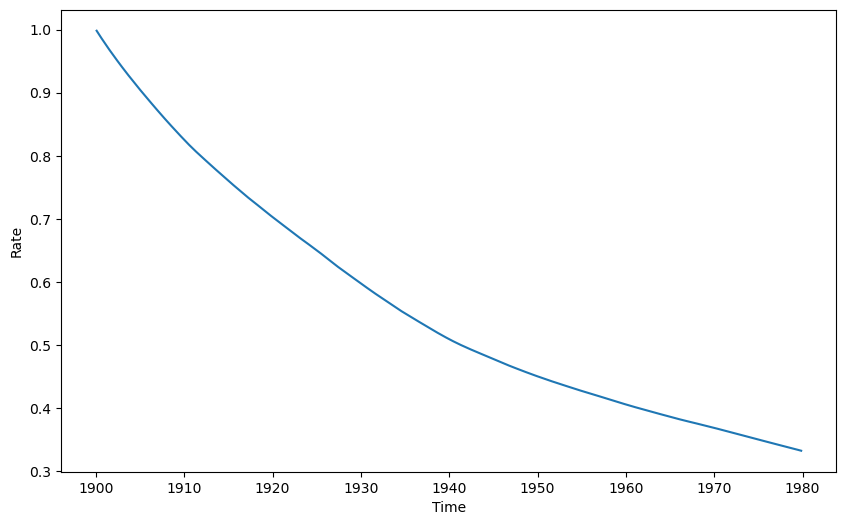

In [1]:
%run date.py
%run calender.py
%run curve.py
%run curveswap.py

In [2]:
import pandas as pd

times = ['1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '12M']
deposits = [5.3305, 5.3315, 5.3165, 5.2905, 5.2605, 5.2355, 5.1983, 5.1625, 5.126, 5.0855, 5.047, 5.01345]

term_list = ['15M', '18M', '24M', '36M', '48M', '60M', '72M', '84M', '96M', '108M', '120M']
input_rate = [4.8525, 4.7225, 4.531, 4.2695, 4.119, 4.0305, 3.9825, 3.9525, 3.9335, 3.924, 3.9185]

deposit_data = pd.DataFrame(list(zip(times, deposits)), columns = ['term','deposits'])
swap_data = pd.DataFrame(list(zip(term_list, input_rate)), columns = ['term','rate'])

deposit_data

,term,deposits
0,1M,5.33050
1,2M,5.33150
2,3M,5.31650
3,4M,5.29050
4,5M,5.26050
5,6M,5.23550
6,7M,5.19830
7,8M,5.16250
8,9M,5.12600
9,10M,5.08550


In [3]:
swap_data

,term,rate
0,15M,4.8525
1,18M,4.7225
2,24M,4.5310
3,36M,4.2695
4,48M,4.1190
5,60M,4.0305
6,72M,3.9825
7,84M,3.9525
8,96M,3.9335
9,108M,3.9240


In [24]:
def preprocess_deposits(eval_date, deposit_data, dcc):
    index = []
    index.append(eval_date)
    for timedelta in deposit_data['term']:
        tenor = Tenor(timedelta)
        date = eval_date + create_relativedelta(tenor.n, tenor.unit)
        # Date roll occurs in Excel Date format, must convert
        d_int = date_roll(pydate_to_exceldate(date), 'US')        
        index.append(exceldate_to_pydate(d_int))  
    df = []
    for i in range(1, len(index)):
        delta = ((index[i] - index[0]).days)/dcc.get_denominator()
        df_ = 1 / (1 + deposit_data['deposits'][i-1]/100 * delta)
        df.append(df_)
    data = pd.DataFrame(list(zip(index[1:], df)), columns = ['date','df'])
    return data

def preprocess_swap(eval_date, swap_data, dcc):
    index = []
    index.append(eval_date)
    for timedelta in swap_data['term']:
        tenor = Tenor(timedelta)
        date = eval_date + create_relativedelta(tenor.n, tenor.unit)
        # Date roll occurs in Excel Date format, must convert
        d_int = date_roll(pydate_to_exceldate(date), 'US')        
        index.append(exceldate_to_pydate(d_int))   
    df_guess = []
    for i in range(1, len(index)):
        delta = ((index[i] - index[0]).days)/dcc.get_denominator()
        df_ = 1 / (1 + deposits[i-1]/100 * delta)
        df_guess.append(df_)
    data = pd.DataFrame(list(zip(index[1:], swap_data['term'], swap_data['rate'], df_guess)), columns = ['date','term','rate','guess_df'])
    return data

In [25]:
spot = dt.date(2024, 3, 25)
guessed_data = preprocess_swap(spot, swap_data, DCC.ACT360)
df_data = preprocess_deposits(spot, deposit_data, DCC.ACT360)

In [30]:
def boostrap_curve(spot_date, deposits, swap_data, dcc):
    disc_curve = Curve(eval_date, deposits['date'], deposits['df'], 'linear') 
    
    for idx, term in enumerate(swap_data['term']):
        tenor = Tenor(term)
        swap = CurveSwap(disc_curve, spot_date, tenor.n, tenor.unit, dcc)
        target = swap_data['rate'][idx]/100

        def g(x):
            disc_curve.set_df(swap_data['date'][idx], x)
            curv_rate = swap.calc_par_rate(disc_curve)
            return target - curv_rate

        y = optimize.newton(g, swap_data['guess_df'][idx])
        disc_curve.set_df(swap_data['date'][idx], y)
        
    return disc_curve

In [31]:
boostrap_curve(spot, df_data, guessed_data, DCC.ACT360).dfs

array([1.        , 0.99543082, 0.99075612, 0.98659551, 0.98238687,
       0.977992  , 0.97393817, 0.97002524, 0.9660588 , 0.9621867 ,
       0.95830485, 0.95488591, 0.95162798, 0.94144717, 0.93187292,
       0.91428142, 0.88108801, 0.84952889, 0.81935903, 0.78970398,
       0.76079987, 0.7326506 , 0.70523838, 0.67854508])

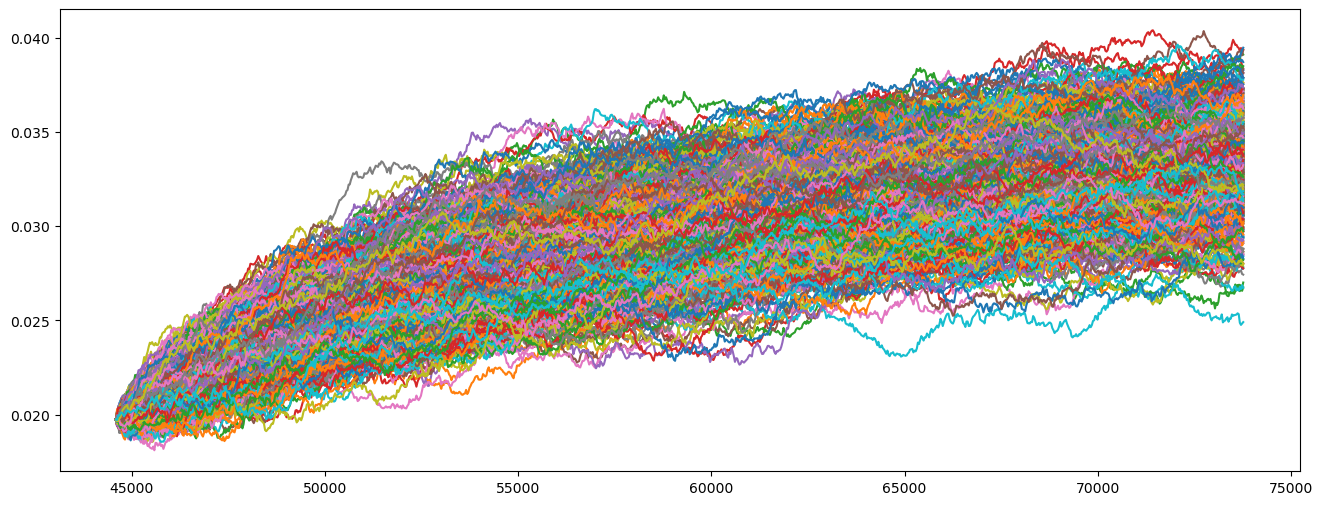

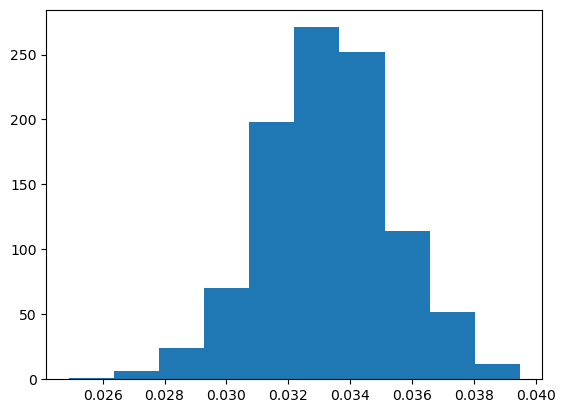

In [19]:
import dateutil 

def plot_Curve():
    dt = dateutil.parser.parse('2022-01-31').date()
    eval_date = pydate_to_exceldate(dt)
    t_xl = np.linspace(eval_date, eval_date+365*80, 1000)
    t_pydate = [exceldate_to_pydate(i) for i in t_xl]
    plt.figure(figsize=(16,6))
    terminals = []
    for i in range(1000):
        curve = CurveMaker.makeCurveFromShortRateModel(t_pydate, 0.02, 0.03, 0.035, 5e-4, 'linear')
        curve.set_interpolator()
        X = t_xl
        Y = curve.get_fwd_rate_aligned(t_xl) # Act/360
        plt.plot(X[:-1], Y)
        terminals.append(Y[998])
    plt.show()
    plt.hist(terminals)

plot_Curve()